In [79]:
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

plt.style.use("seaborn-v0_8")
import argparse
import logging
import os

from DA_PoC.common.observation_operator import (
    IdentityObservationOperator,
)  # RandomObservationOperator,; LinearObervationOperator,
from DA_PoC.dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    burn_model,
    create_lorenz_model_observation,
)
from DA_PoC.variational.incrementalCG import Incremental4DVarCG, pad_ragged

logging.basicConfig(level=logging.INFO)
logs_path = os.path.join(os.sep, "root", "log_dump", "smoke")
smoke_path = os.path.join(os.sep, "home", "smoke")
artifacts_path = os.path.join(smoke_path, "artifacts")

plt.set_cmap("magma")


rng = np.random.default_rng(seed=93)


def main(config, n, loaded_model=None):
    if n is None:
        n = config["model"]["dimension"]
    window = 20
    lorenz = LorenzWrapper(n)
    x0_t = burn_model(lorenz, 1000)
    lorenz.n_total_obs = window

    m = n * (window + 1)
    lorenz.set_observations(window)
    lorenz.H = lambda x: x
    lorenz.background = np.zeros(n)
    lorenz.background_error_cov_inv = np.zeros((n,n))


    identity_obs_operator = IdentityObservationOperator(m)
    l_model_randobs = create_lorenz_model_observation(
        lorenz, identity_obs_operator, test_consistency=False
    )

    def get_next_obs(x0):
        return lorenz.get_next_observations(
            x0,
            model_error_sqrt=config["DA"]["model_error_sqrt"],
            obs_error_sqrt=config["DA"]["obs_error_sqrt"],
        )

    # obs, x_t, truth = get_next_obs(x0_t)

    n_cycle = config["DA"]["n_cycle"]  # 3
    n_outer = config["DA"]["n_outer"]  # 10
    n_inner = config["DA"]["n_inner"]  # 100
    log_file = config["DA"]["log_file"]


    DA_exp_dict = {}

    def create_DA_experiment(exp_name, prec):
        DA_exp = Incremental4DVarCG(
            state_dimension=n,
            bounds=None,
            numerical_model=l_model_randobs,
            observation_operator=identity_obs_operator,
            x0_run=x0_t,
            x0_analysis=None,
            get_next_observations=get_next_obs,
            n_cycle=n_cycle,
            n_outer=n_outer,
            n_inner=n_inner,
            prec=prec,
            plot=False,
            log_append=False,
            save_all=True,
        )
        DA_exp.GNlog_file = log_file
        DA_exp.exp_name = exp_name
        DA_exp_dict[exp_name] = DA_exp
        return DA_exp

    DA_baseline = create_DA_experiment("baseline", prec=None)

    for exp_name, DA_exp in DA_exp_dict.items():
        print(f"\n--- {exp_name} ---\n")
        DA_exp.run()

    for i, (exp_name, DA_exp) in enumerate(DA_exp_dict.items()):
        DA_exp.plot_residuals_inner_loop(
            f"C{i}", label=DA_exp.exp_name, cumulative=False
        )
    plt.legend()
    plt.ylim([1e-9, 1e2])
    plt.show()
    return DA_exp_dict



<Figure size 800x550 with 0 Axes>

In [21]:
config = OmegaConf.load("config.yaml")

In [22]:
config['DA']['model_error_sqrt'] = 1.0
config['DA']['obs_error_sqrt'] = 1.0
config['model']['dim'] = 20

In [23]:
print(config['DA'])

{'n_cycle': 10, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 1.0, 'obs_error_sqrt': 1.0, 'log_file': '/home/smoke/artifacts/DA_logs.csv'}


Observation operator set already
lorenz.cost_function(x0_t)=2048.415386036524
numerical_model_lorenz.cost_function(x0_t)=2048.415386036524

--- baseline ---

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     0,     0, 1099.9293,       22,  46.97, 1.642e+01, 1.642e+01
baseline,     0,     1, 459.3671,       21,  46.46, 1.250e+01, 1.250e+01
baseline,     0,     2, 359.7751,       20,  46.52, 1.261e+01, 1.261e+01
baseline,     0,     3, 355.7515,       18,  46.54, 1.277e+01, 1.277e+01
baseline,     0,     4, 355.4528,       17,  46.53, 1.276e+01, 1.276e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     1,     0, 1488.5796,       22,  46.63, 1.319e+01, 1.319e+01
baseline,     1,     1, 462.1902,       23,  47.57, 2.276e+01, 2.276e+01
baseline,     1,     2, 325.8221,       23,  47.72, 2.472e+01, 2.472e+01
baseline,     1,     3, 318.7448,       22,  47.80, 2.561e+01, 2.561e+01
baseline,     1,     4, 318.5879,    

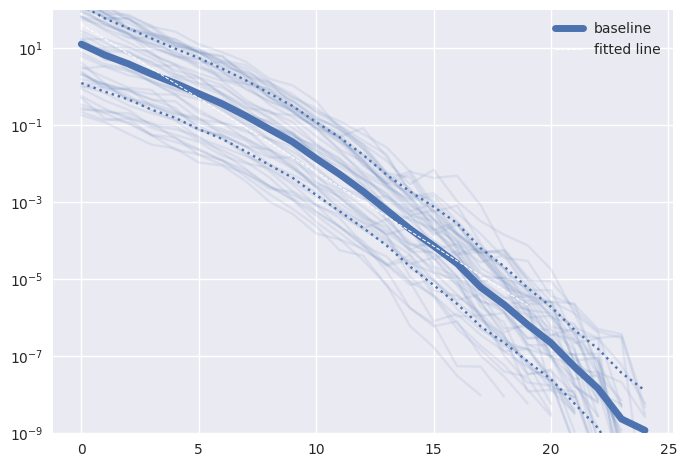

In [24]:
DA_exp_dict = main(config=config, n=20)

In [25]:
baseline = DA_exp_dict["baseline"]

In [26]:
baseline.plot

False

In [27]:
baseline.__dict__.keys()

dict_keys(['state_dimension', 'bounds', 'numerical_model', 'observation_operator', 'x0_run', 'x0_analysis', 'get_next_observations', 'n_cycle', 'n_outer', 'n_inner', 'preconditioner', 'plot', 'run_summary', 'GNlog_file', 'exp_name', 'save_all'])

In [28]:
for k, val in baseline.run_summary.items():
    try:
        print(f"{k}, {val.shape}")
    except AttributeError:
        try:
            print(f"{k}, {type(val)}, {len(val)}")
        except TypeError:
            print(f"{k}, {type(val)}")

truth_full, (20, 100)
analysis_full, (20, 100)
obs_full, (20, 100)
n_iter_innerloop, <class 'list'>, 10
cost_outerloop, <class 'list'>, 10
sp_optimisation, <class 'list'>, 0
quad_errors, <class 'list'>, 10
l_model, <class 'DA_PoC.common.numerical_model.NumericalModel'>
inner_res_cycle, <class 'list'>, 10


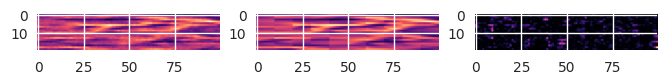

In [29]:
plt.subplot(1, 3, 1)
plt.imshow(baseline.run_summary['truth_full'])
plt.subplot(1, 3, 2)
plt.imshow(baseline.run_summary['analysis_full'])
plt.subplot(1, 3, 3)
plt.imshow((baseline.run_summary['truth_full'] - baseline.run_summary['analysis_full'])**2)


In [30]:
n = 40
window = 10
lorenz = LorenzWrapper(n)
x0_t = burn_model(lorenz, 1000)
lorenz.n_total_obs = window

m = n * (window + 1)
lorenz.background_error_cov_inv = np.zeros((n, n))
lorenz.background = np.zeros(n)
lorenz.set_observations(nobs=window)
lorenz.H = lambda x: x

identity_obs_operator = IdentityObservationOperator(m)
l_model_randobs = create_lorenz_model_observation(
    lorenz, identity_obs_operator, test_consistency=False
)

def get_next_obs(x0):
    return lorenz.get_next_observations(
        x0,
        model_error_sqrt=config["DA"]["model_error_sqrt"],
        obs_error_sqrt=config["DA"]["obs_error_sqrt"],
    )
obs, x_t, truth = get_next_obs(np.random.normal(size=n))
truth = truth[:, 1:]

# self.numerical_model.set_obs(self.observation_operator(obs.reshape(-1)))

Observation operator set already
lorenz.cost_function(x0_t)=4668.845679793155
numerical_model_lorenz.cost_function(x0_t)=4668.845679793155


In [31]:
print(l_model_randobs)

NumericalModel:
- state_dimension: n=40
- obs dimension: m=440
- obs operator initialized: True
- background set: True
- observations set: True


In [32]:
x0_t = np.random.normal(size=n)
Jb = 0.5 * lorenz.background_cost(x0_t)

In [33]:
print(Jb)

0.0


In [34]:
d = lorenz.data_misfit(x0_t)
J0 = 0.5 * d.T @ d
print(f"{(J0 + Jb)=}")
l_model_randobs.cost_function(x0_t)

(J0 + Jb)=4474.029287568831


4474.029287568831

In [35]:
n_cycle = 5
n_outer = 5
n_inner = 20
x0_t = burn_model(lorenz, 1000)

In [36]:
DA_exp = Incremental4DVarCG(
    state_dimension=n,
    bounds=None,
    numerical_model=l_model_randobs,
    observation_operator=identity_obs_operator,
    x0_run=x0_t,
    x0_analysis=None,
    get_next_observations=get_next_obs,
    n_cycle=n_cycle,
    n_outer=n_outer,
    n_inner=n_inner,
    prec=None,
    plot=False,
    log_append=True,
    save_all=True,
)
DA_exp.run('baseline')

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     0,     0, 1398.8091,       20,  92.63, 1.658e+01, 1.658e+01
baseline,     0,     1, 768.5451,       20,  93.21, 2.174e+01, 2.174e+01
baseline,     0,     2, 667.3487,       20,  93.29, 2.051e+01, 2.051e+01
baseline,     0,     3, 662.1160,       20,  93.33, 2.134e+01, 2.134e+01
baseline,     0,     4, 661.7984,       20,  93.34, 2.140e+01, 2.140e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     1,     0, 3095.0227,       20,  93.33, 3.113e+01, 3.113e+01
baseline,     1,     1, 1061.7002,       20,  95.35, 2.942e+01, 2.942e+01
baseline,     1,     2, 616.3648,       20,  96.06, 3.654e+01, 3.654e+01
baseline,     1,     3, 595.7137,       20,  96.32, 3.996e+01, 3.996e+01
baseline,     1,     4, 595.2935,       20,  96.34, 3.961e+01, 3.961e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
baseline,     2,     0, 2328.9738,       20,  95

{'truth_full': array([[ 2.88963691,  2.54502616,  0.82538662, ..., -2.18679119,
         -1.15861259, -2.01765773],
        [-2.46455251, -3.32706004, -5.90007118, ..., -1.84790698,
         -1.37526267, -0.4716401 ],
        [-0.30960091, -0.9465974 ,  1.77529382, ..., -0.04710496,
         -0.65596991, -0.9106706 ],
        ...,
        [ 2.79330703,  3.12242827,  4.14218856, ...,  4.23724957,
          5.20763416,  5.43683222],
        [ 3.81131659,  5.31253552,  6.48417496, ...,  3.5788819 ,
          5.48486509,  4.30703287],
        [ 6.99497703,  6.02364108,  4.59866795, ..., -1.71483483,
         -1.44733497, -1.8138773 ]]),
 'analysis_full': array([[ 3.8174718 ,  2.749023  ,  1.63064584, ..., -2.47650625,
         -2.2369603 , -1.99832214],
        [-5.81400485, -5.97585957, -5.96238627, ...,  0.2677353 ,
          0.29440761,  0.32411235],
        [-1.43598272, -0.88505116, -0.46013413, ...,  1.43428214,
          1.62986262,  1.8282643 ],
        ...,
        [ 4.78797546,  

In [37]:
from DA_PoC.common.linearsolver import solve_cg, conjGrad
from DA_PoC.common.preconditioned_solvers import PreconditionedSolver


# class PreconditionedSolver:
#     def __init__(self, tol: float = 1e-8, maxiter: int = 100):
#         self.tol = tol
#         self.maxiter = maxiter

#     def __call__(
#         self, A: np.ndarray, b: np.ndarray, x: np.ndarray, maxiter: int = None
#     ):
#         if maxiter is not None:
#             self.maxiter = maxiter
#         return conjGrad(A, x, b, tol=self.tol, maxiter=self.maxiter)


class PseudoInverseStart(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank

    def __call__(self, A, b, x, maxiter):
        U, S, Vt = np.linalg.svd(A)
        A_dagger = U[:, :self.rank] @ (S[:self.rank]**(-1) * U[:, :self.rank]).T
        return conjGrad(A, A_dagger @ b, b, tol=self.tol, maxiter=self.maxiter, verbose=False)


class BalancingPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank

    def __call__(self, A, b, x, maxiter):
        U, S, Vt = np.linalg.svd(A)
        A_dagger = U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
        return conjGrad(A_dagger @ A, 0*b, A_dagger @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)

    def get_prec(self, A):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
    
    def power_inv(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


class SplitPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank
    
    def power_prec(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


    def __call__(self, A, b, x, maxiter):
        L = self.power_prec(A, power=-0.5)
        # Linv = self.power_prec(A, power=0.5)
        x_hat, res_dict = conjGrad(L.T @ A @ L, 0*b, L.T @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)
        return L @ x_hat, res_dict

A_ = np.random.normal(size=(20, 20))
A = A_.T @ A_
x = np.arange(20)
SplitPrec()(A, A@x, None, None)
# A_ = np.random.normal(size=(20, 20))
# A = A_.T @ A_
# L = BalancingPrec(rank=10).power_inv(A, power=-0.5)
# print(L.T @ A @L)
# plt.plot(np.linalg.eigvalsh(L.T @ A @ L))
# plt.plot(np.linalg.eigvalsh(A))

# L2 = BalancingPrec(rank=10).power_inv(A, power=0.5)
# L @ L2

# np.linalg.

(array([9.14557319e-12, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
        4.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00,
        8.00000000e+00, 9.00000000e+00, 1.00000000e+01, 1.10000000e+01,
        1.20000000e+01, 1.30000000e+01, 1.40000000e+01, 1.50000000e+01,
        1.60000000e+01, 1.70000000e+01, 1.80000000e+01, 1.90000000e+01]),
 {'success': True,
  'niter': 21,
  'residuals': [array([ 54.06826563, -99.69746907,  -5.3248907 , 106.55503139,
          218.22846613, -68.60966863,  98.14010362, 185.01694604,
          175.8541338 , 157.36984958,  73.39158102,  31.9972539 ,
          161.57548528, 288.3205628 , 248.51849494, 200.69728994,
           -2.41226646, 403.80987661, 232.07384199, 166.18777908]),
   array([  15.36191638,   29.80571328,   20.96832432,   -9.21959088,
          -105.36448954,   75.91267122,   58.93611833,  -20.0346749 ,
            39.51511264,  -80.49488666,   71.60162415,  104.30166063,
            31.44792838,   36.09300393,   25.0172

: log(residuals) = 3.46 +  -0.62 * i
First 20 it, : log(residuals) = 3.42 +  -0.61 * i
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
   pse 0,     0,     0, 1425.8828,       20,  93.46, 2.081e+01, 2.081e+01
   pse 0,     0,     1, 713.0795,       20,  93.54, 1.736e+01, 1.736e+01
   pse 0,     0,     2, 653.3256,       20,  93.55, 1.754e+01, 1.754e+01
   pse 0,     0,     3, 652.3717,       20,  93.60, 1.794e+01, 1.794e+01
   pse 0,     0,     4, 652.3471,       20,  93.59, 1.795e+01, 1.795e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
   pse 0,     1,     0, 2945.1028,       20,  93.35, 2.060e+01, 2.060e+01
   pse 0,     1,     1, 1150.5937,       20,  95.10, 3.927e+01, 3.927e+01
   pse 0,     1,     2, 615.7503,       20,  95.78, 4.103e+01, 4.103e+01
   pse 0,     1,     3, 596.2342,       20,  96.02, 4.270e+01, 4.270e+01
   pse 0,     1,     4, 595.6266,       20,  96.03, 4.269e+01, 4.269e+01
    #exp, ncycle, nouter,     f(x)

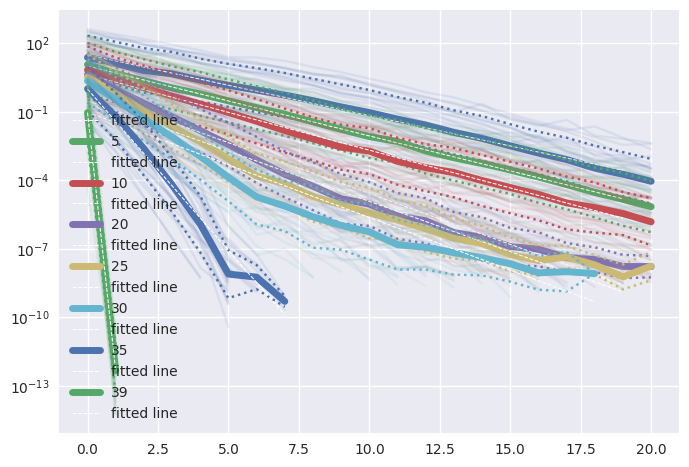

In [38]:
DA_exp.plot_residuals_inner_loop("C0")

for i, rank in enumerate([5, 10, 20, 25, 30 ,35, 39]):
    DA_pse = Incremental4DVarCG(
        state_dimension=n,
        bounds=None,
        numerical_model=l_model_randobs,
        observation_operator=identity_obs_operator,
        x0_run=x0_t,
        x0_analysis=None,
        get_next_observations=get_next_obs,
        n_cycle=n_cycle,
        n_outer=n_outer,
        n_inner=n_inner,
        prec=PseudoInverseStart(rank=rank, maxiter=n_inner),
        plot=False,
        log_append=True,
        save_all=True,
    )
    DA_pse.run(f'pse {i}')
    DA_pse.plot_residuals_inner_loop(f"C{i+1}", label=f'{rank}')

plt.legend()

In [39]:
class BalancingPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank

    def __call__(self, A, b, x, maxiter):
        U, S, Vt = np.linalg.svd(A)
        A_dagger = U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
        return conjGrad(A_dagger @ A, 0*b, A_dagger @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)

    def get_prec(self, A):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(-1) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])
    
    def power_inv(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


class SplitPrec(PreconditionedSolver):
    def __init__(self, rank: int=5, tol: float = 1e-8, maxiter: int = 100):
        super().__init__(tol, maxiter)
        self.rank = rank
    
    def power_prec(self, A, power):
        U, S, Vt = np.linalg.svd(A)
        return U[:, :self.rank] @ ((S[:self.rank]**(power) - 1) * U[:, :self.rank]).T + np.eye(S.shape[0])


    def __call__(self, A, b, x, maxiter):
        L = self.power_prec(A, power=-0.5)
        # Linv = self.power_prec(A, power=0.5)
        x_hat, res_dict = conjGrad(L.T @ A @ L, 0*b, L.T @ b, tol=self.tol, maxiter=self.maxiter, verbose=False)
        return L @ x_hat, res_dict

A_ = np.random.normal(size=(20, 20))
A = A_.T @ A_
x = np.arange(20)
SplitPrec()(A, A@x, None, None)
# A_ = np.random.normal(size=(20, 20))
# A = A_.T @ A_
# L = BalancingPrec(rank=10).power_inv(A, power=-0.5)
# print(L.T @ A @L)
# plt.plot(np.linalg.eigvalsh(L.T @ A @ L))
# plt.plot(np.linalg.eigvalsh(A))

# L2 = BalancingPrec(rank=10).power_inv(A, power=0.5)
# L @ L2

# np.linalg.

(array([1.08927622e-09, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
        4.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00,
        8.00000000e+00, 9.00000000e+00, 1.00000000e+01, 1.10000000e+01,
        1.20000000e+01, 1.30000000e+01, 1.40000000e+01, 1.50000000e+01,
        1.60000000e+01, 1.70000000e+01, 1.80000000e+01, 1.90000000e+01]),
 {'success': True,
  'niter': 24,
  'residuals': [array([ 24.94911849,  -1.67907571,  92.09178   ,  48.6680615 ,
          208.2032617 ,  48.11519927,  65.88461316,  22.57144548,
          103.49641499,  21.41765613, 147.34774267, 148.73043579,
          193.66213148, 139.13560641, -53.00084598, 133.72044154,
          212.99822352,  21.18649897, 140.73022319, 152.09047745]),
   array([-106.05240075,   98.33292989,    2.79118444,  -16.66940766,
           -58.93131262,   52.38491423,  -55.07912416,   46.67490476,
            39.49577521,  127.39530375,  -29.43111323,   -3.67937419,
           -25.45615553,   76.84244033,   86.2419

: log(residuals) = 3.46 +  -0.62 * i
First 20 it, : log(residuals) = 3.42 +  -0.61 * i
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
   pse 0,     0,     0, 1572.2117,       20,  93.12, 1.958e+01, 2.722e+01
   pse 0,     0,     1, 680.9149,       20,  91.85, 1.526e+01, 2.297e+01
   pse 0,     0,     2, 622.3141,       20,  92.01, 1.815e+01, 2.362e+01
   pse 0,     0,     3, 619.8293,       20,  92.04, 1.823e+01, 2.410e+01
   pse 0,     0,     4, 619.7065,       19,  92.04, 1.827e+01, 2.421e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
   pse 0,     1,     0, 2322.1329,       20,  92.20, 1.836e+01, 2.146e+01
   pse 0,     1,     1, 727.7850,       20,  93.16, 2.301e+01, 2.589e+01
   pse 0,     1,     2, 588.9718,       20,  93.46, 2.515e+01, 2.716e+01
   pse 0,     1,     3, 585.9389,       20,  93.52, 2.576e+01, 2.741e+01
   pse 0,     1,     4, 585.8178,       20,  93.53, 2.591e+01, 2.755e+01
    #exp, ncycle, nouter,     f(x),

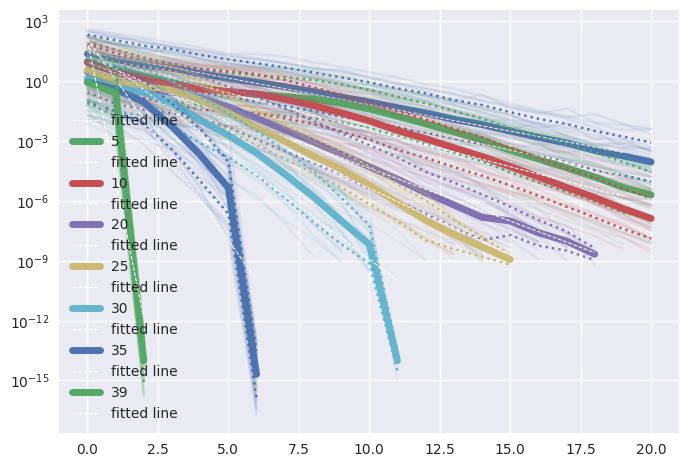

In [40]:
DA_exp.plot_residuals_inner_loop("C0")

for i, rank in enumerate([5, 10, 20, 25, 30 ,35, 39]):
    DA_bal = Incremental4DVarCG(
        state_dimension=n,
        bounds=None,
        numerical_model=l_model_randobs,
        observation_operator=identity_obs_operator,
        x0_run=x0_t,
        x0_analysis=None,
        get_next_observations=get_next_obs,
        n_cycle=n_cycle,
        n_outer=n_outer,
        n_inner=n_inner,
        prec=BalancingPrec(rank=rank, maxiter=n_inner),
        plot=False,
        log_append=True,
        save_all=True,
    )
    DA_bal.run(f'pse {i}')
    DA_bal.plot_residuals_inner_loop(f"C{i+1}", label=f'{rank}')

plt.legend()

: log(residuals) = 3.46 +  -0.62 * i
First 20 it, : log(residuals) = 3.42 +  -0.61 * i
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
   pse 0,     0,     0, 1195.3713,       20,  92.80, 1.461e+01, 2.272e+01
   pse 0,     0,     1, 551.8666,       20,  92.56, 1.183e+01, 2.861e+01
   pse 0,     0,     2, 512.7176,       20,  92.89, 1.283e+01, 3.069e+01
   pse 0,     0,     3, 512.2695,       20,  92.89, 1.283e+01, 3.067e+01
   pse 0,     0,     4, 512.2619,       20,  92.89, 1.284e+01, 3.067e+01
   pse 0,     0,     5, 512.2618,       18,  92.89, 1.284e+01, 3.067e+01
   pse 0,     0,     6, 512.2618,       17,  92.89, 1.284e+01, 3.067e+01
   pse 0,     0,     7, 512.2618,       15,  92.89, 1.284e+01, 3.067e+01
   pse 0,     0,     8, 512.2618,       14,  92.89, 1.284e+01, 3.067e+01
   pse 0,     0,     9, 512.2618,       13,  92.89, 1.284e+01, 3.067e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec
   pse 0,     1,     0, 2004.8197,  

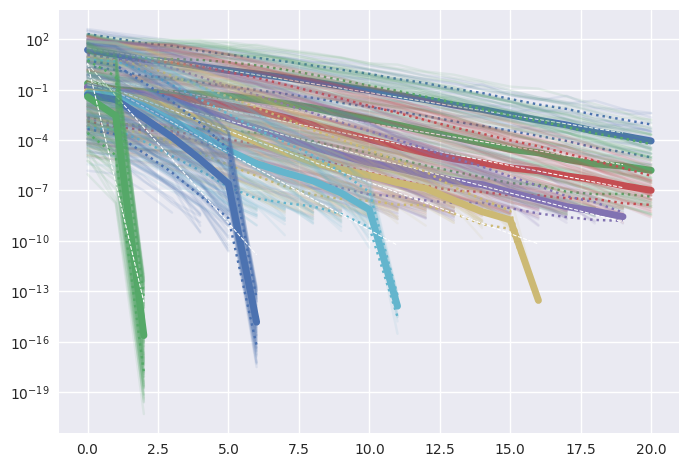

In [41]:
DA_exp.plot_residuals_inner_loop("C0")
for i, rank in enumerate([5, 10, 20, 25, 30 ,35, 39]):
    DA_spli = Incremental4DVarCG(
        state_dimension=n,
        bounds=None,
        numerical_model=l_model_randobs,
        observation_operator=identity_obs_operator,
        x0_run=x0_t,
        x0_analysis=None,
        get_next_observations=get_next_obs,
        n_cycle=n_cycle*2,
        n_outer=n_outer*2,
        n_inner=n_inner,
        prec=SplitPrec(rank=rank, maxiter=n_inner),
        plot=False,
        log_append=True,
        save_all=True,
    )
    DA_spli.run(f'pse {i}')
    DA_spli.plot_residuals_inner_loop(f"C{i+1}", label=f'{rank}')


In [45]:
DA_spli.run_summary['truth_full'].shape

(40, 100)

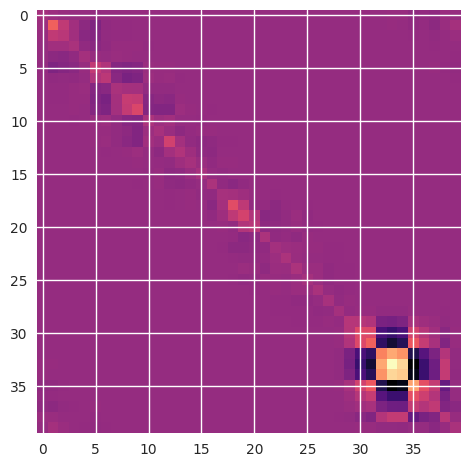

In [65]:
import sys
sys.path.append('..')

import mlflow
logged_model = f"runs:/1fc099175a1946da9db33fe34722a63b/smoke_model"
mlflow.pyfunc.get_model_dependencies(logged_model)
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(f"{loaded_model=}")
# except:
# loaded_model = None



def construct_svd_ML(loaded_model, x_, qr=True):
    pred = loaded_model.predict(np.asarray(x_).astype("f"))
    Ur, logsvals = pred[:, :-1, :], pred[:, -1, :]
    Sr = np.exp(logsvals)
    if qr:
        Ur = np.linalg.qr(Ur)[0]
    return Sr.squeeze(), Ur.squeeze()


2023/05/26 13:20:17 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r /tmp/tmpobbe4mrp/smoke_model/requirements.txt'.
2023/05/26 13:20:18 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 1.23.5, required: numpy==1.21.5)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


loaded_model=mlflow.pyfunc.loaded_model:
  artifact_path: smoke_model
  flavor: mlflow.pytorch
  run_id: 1fc099175a1946da9db33fe34722a63b



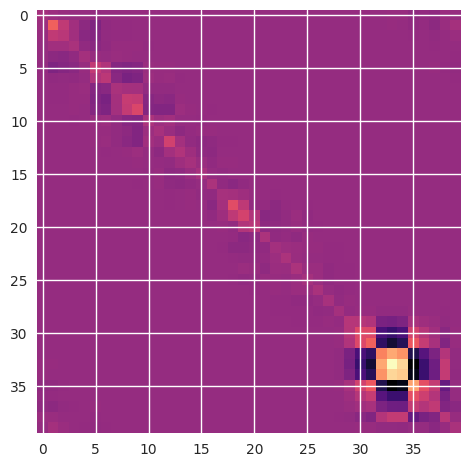

In [62]:
state = DA_spli.run_summary['truth_full'][:, -1]
GN_mat = l_model_randobs.gauss_newton_hessian_matrix(state)
plt.imshow(GN_mat)

In [66]:
Sr, Ur = construct_svd_ML(loaded_model, x_=state.reshape(1, 40))
Ur.shape

(40, 35)

In [67]:
GN_ml = Ur @ (Sr[None, :] * Ur).T

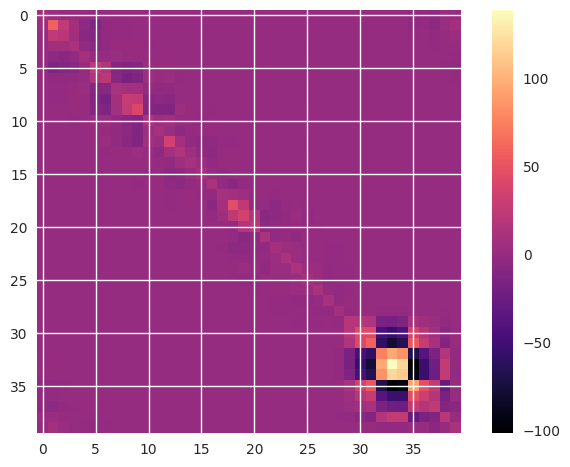

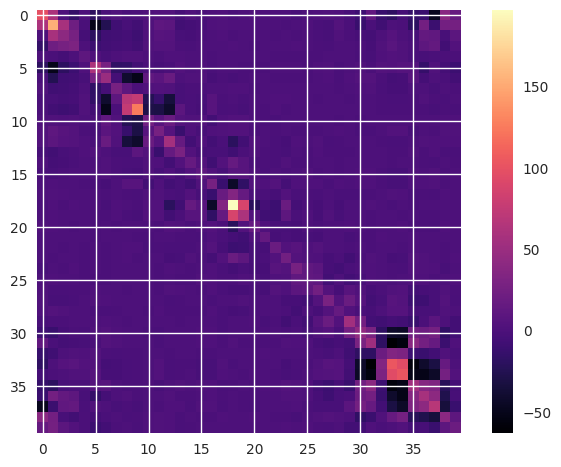

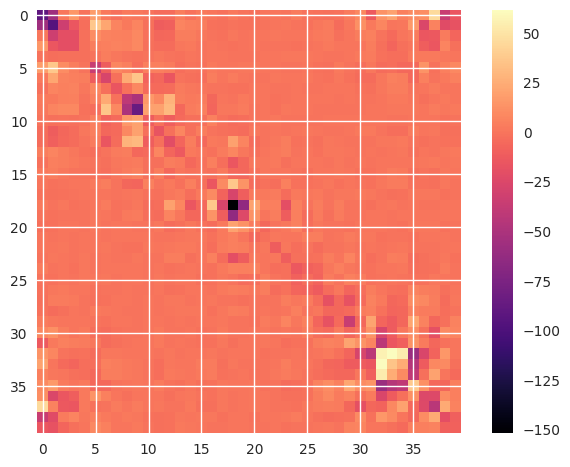

In [73]:
plt.imshow(GN_mat)
plt.colorbar()
plt.figure()
plt.imshow(GN_ml)
plt.colorbar()
plt.figure()
plt.imshow(GN_mat - GN_ml)
plt.colorbar()

In [74]:
U, S, _ = np.linalg.svd(GN_mat)

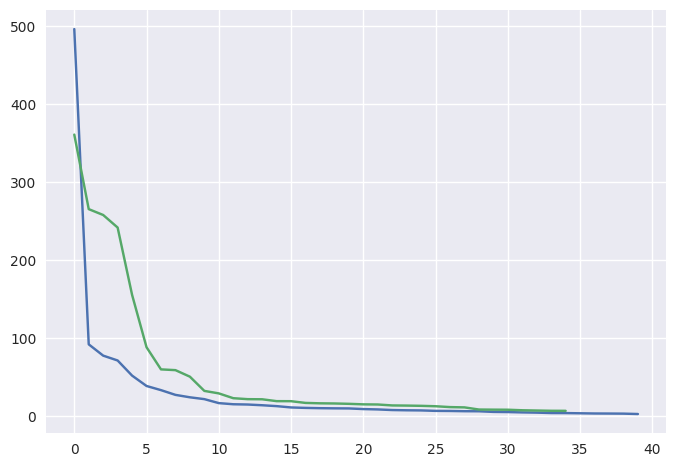

In [78]:
plt.plot(S)
plt.plot(np.sort(Sr)[::-1])